## 连接数据库

In [50]:
from google.cloud.sql.connector import Connector, IPTypes
import sqlalchemy
from google.oauth2 import service_account
from sqlalchemy import text
#pip install cloud-sql-python-connector

# 指定服务账户文件路径
SERVICE_ACCOUNT_FILE = 'qf5214_hhy.json'
                                                            #各自修改成自己的密钥文件
# 创建服务账户凭据
credentials = service_account.Credentials.from_service_account_file(
    SERVICE_ACCOUNT_FILE
)

# 初始化Connector对象
connector = Connector(credentials=credentials)

def getconn() -> sqlalchemy.engine.base.Connection:
    # 连接信息
    instance_connection_string = "supple-folder-418707:us-central1:qf5214project"
    db_user = "user_wxc"
    db_pass = "5214group4_cloud_wxc"
    db_name = "bitcoin_wxc"                                       # 替换为你的实际数据库名，不过没有好像也可以

    conn = connector.connect(
        instance_connection_string,
        "pymysql",  
        user=db_user,
        password=db_pass,
        db=db_name,
        ip_type=IPTypes.PUBLIC,  # 使用公共IP进行访问
    )
    return conn

# 创建SQLAlchemy engine
engine = sqlalchemy.create_engine(
    "mysql+pymysql://galvanic-smoke-419511:us-central1:huanghaoyang123@34.42.207.66/qf5214",  # 我们的数据库是MySQL8.0
    creator=getconn,
)

# 使用engine进行数据库操作
with engine.connect() as conn:
    result = conn.execute(text("SELECT NOW();"))  # 使用text()包裹原始SQL语句，否则报错
    for row in result:
        print(row)      #返回数据库时间


(datetime.datetime(2024, 4, 12, 11, 8, 34),)


In [51]:
with engine.connect() as connection:
    # 获取所有数据库名称
    databases = connection.execute(text("SHOW DATABASES"))
    databases_names = [db[0] for db in databases]
    
    for db_name in databases_names:
        # 跳过系统数据库
        if db_name in ['information_schema', 'mysql', 'performance_schema', 'sys']:
            continue

        print(f"\n数据库 '{db_name}' 包含的表有：")
        
        # 对于每个数据库，查询其包含的表
        # 在查询表之前，需要切换到那个数据库
        connection.execute(text(f"USE {db_name}"))
        tables = connection.execute(text("SHOW TABLES"))
        for table in tables:
            print(table[0])


数据库 'Bitcoin_data' 包含的表有：
market
news
talk_comments
talk_subjects
talk_users

数据库 'bitcoin_test1' 包含的表有：
news

数据库 'bitcoin_testmwf' 包含的表有：
market
news
talk_comments
talk_subjects
talk_users

数据库 'bitcoin_wxc' 包含的表有：
market
news
talk_comments
talk_subjects
talk_users


In [52]:
import pandas as pd
# 使用Pandas的read_sql_query函数查询btc_daily_info表的列信息
query = """
SELECT COLUMN_NAME 
FROM information_schema.COLUMNS 
WHERE 
    TABLE_SCHEMA = 'bitcoin_wxc' AND 
    TABLE_NAME = 'market';
"""
df_columns = pd.read_sql_query(query, engine)

print(df_columns)

     COLUMN_NAME
0      btc_price
1     btc_volume
2            cpi
3           date
4      eth_price
5     eth_volume
6       fed_rate
7   nofarm_ratio
8        nonfarm
9     population
10          sofr


In [53]:
# 使用Pandas的read_sql_query函数加载数据
query = """
SELECT date, btc_price, btc_volume, cpi, fed_rate 
FROM market 
WHERE date >= '2011-07-01'
"""

df = pd.read_sql_query(query, engine)

print(df.head(30))  # 打印前几行数据以验证

          date  btc_price  btc_volume      cpi  fed_rate
0   2011-07-01       15.4     33280.0  225.922      0.07
1   2011-07-02       15.4     19450.0  225.922      0.07
2   2011-07-03       15.4     16790.0  225.922      0.07
3   2011-07-04       13.9     52280.0  225.922      0.07
4   2011-07-05       12.9     84080.0  225.922      0.07
5   2011-07-06       14.8    111820.0  225.922      0.07
6   2011-07-07       14.8     54470.0  225.922      0.07
7   2011-07-08       14.3     34850.0  225.922      0.07
8   2011-07-09       14.4     11910.0  225.922      0.07
9   2011-07-10       14.9     45280.0  225.922      0.07
10  2011-07-11       14.2     49160.0  225.922      0.07
11  2011-07-12       14.0     26360.0  225.922      0.07
12  2011-07-13       13.9     10340.0  225.922      0.07
13  2011-07-14       14.0     17660.0  225.922      0.07
14  2011-07-15       13.8     24820.0  225.922      0.07
15  2011-07-16       13.7     17260.0  225.922      0.07
16  2011-07-17       13.2     3

/var/folders/c5/ddxzvxjn4j99j21fhtmd500c0000gn/T/ipykernel_33315/1140146929.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


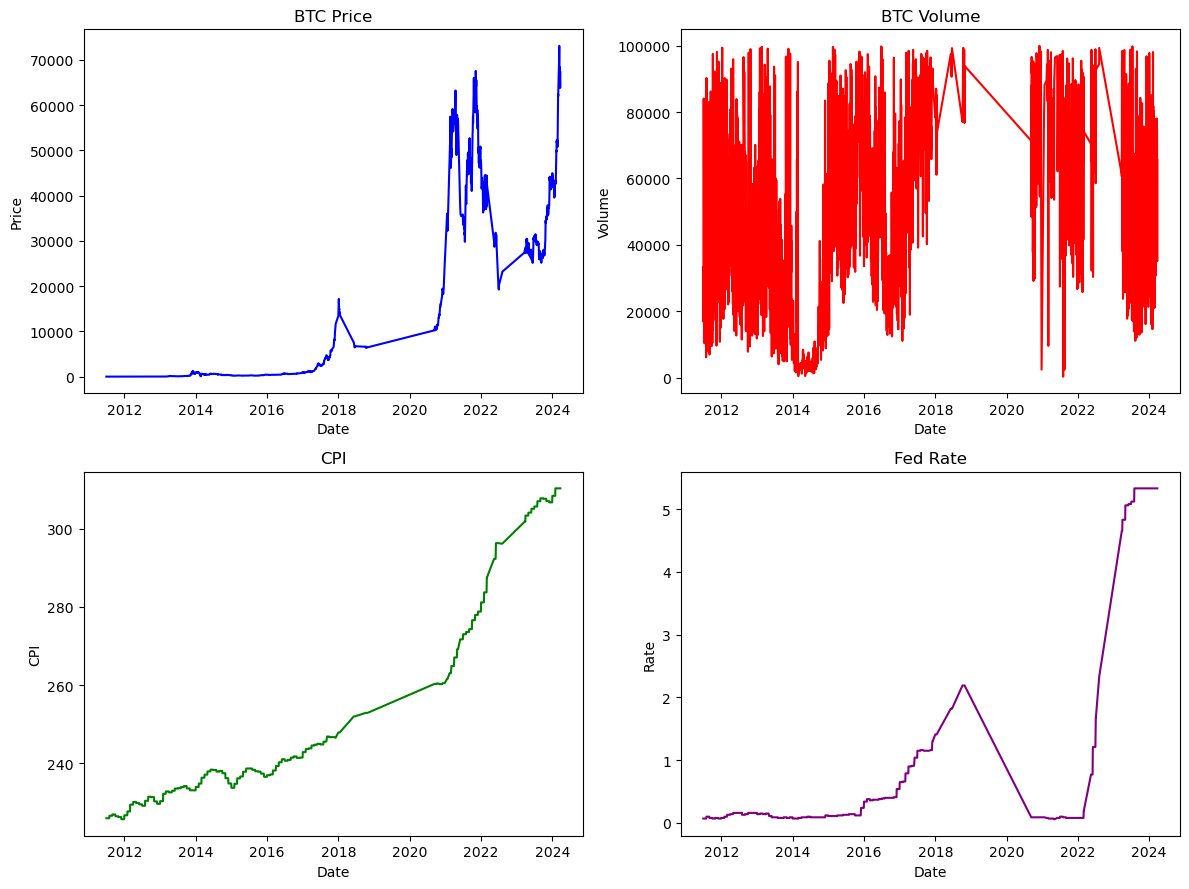

In [133]:
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

# 确保'date'列是日期类型
df['date'] = pd.to_datetime(df['date'])
# 条件筛选并保留符合条件的行
df = df[df['btc_volume'] <= 1e5]
# 设置整个图表的大小
plt.figure(figsize=(12, 9))  # 调整整个画布的大小，适应两列的布局

# 创建第一个子图：BTC Price
plt.subplot(2, 2, 1) # (行数，列数，子图编号)
plt.plot(df['date'], df['btc_price'], color='blue')
plt.title('BTC Price')
plt.xlabel('Date')
plt.ylabel('Price')

# 创建第二个子图：BTC Volume
plt.subplot(2, 2, 2)
plt.plot(df['date'], df['btc_volume'], color='red')
plt.title('BTC Volume')
plt.xlabel('Date')
plt.ylabel('Volume')

# 创建第三个子图：CPI
plt.subplot(2, 2, 3)
plt.plot(df['date'], df['cpi'], color='green')
plt.title('CPI')
plt.xlabel('Date')
plt.ylabel('CPI')

# 创建第四个子图：Fed Rate
plt.subplot(2, 2, 4)
plt.plot(df['date'], df['fed_rate'], color='purple')
plt.title('Fed Rate')
plt.xlabel('Date')
plt.ylabel('Rate')

# 调整子图间距
plt.tight_layout()

# 显示图表
plt.show()


## 描述性统计

In [134]:
import numpy as np


# 计算描述性统计量
descriptive_stats = df.describe()

# 打印描述性统计结果
print(descriptive_stats)

# 除了常规的描述性统计量，还可以计算其他有用的统计数据

# 计算变异系数(CV)，评估数据的离散程度
cv = lambda x: np.std(x, ddof=1) / np.mean(x) * 100  # ddof=1 用于样本标准差
btc_price_cv = cv(df['btc_price'])
btc_volume_cv = cv(df['btc_volume'])
cpi_cv = cv(df['cpi'])
fed_rate_cv = cv(df['fed_rate'])

print(f"BTC Price CV: {btc_price_cv:.2f}%")
print(f"BTC Volume CV: {btc_volume_cv:.2f}%")
print(f"CPI CV: {cpi_cv:.2f}%")
print(f"Fed Rate CV: {fed_rate_cv:.2f}%")


          btc_price    btc_volume          cpi     fed_rate
count   2735.000000   2735.000000  2735.000000  2735.000000
mean    9935.118245  44650.939671   249.453271     0.850388
std    17465.071128  26243.994656    25.593602     1.648488
min        2.000000    260.000000   225.672000     0.060000
25%      129.300000  23520.000000   233.504000     0.090000
50%      477.100000  42580.000000   238.031000     0.130000
75%    10776.150000  64695.000000   260.229000     0.400000
max    73066.300000  99970.000000   310.326000     5.330000
BTC Price CV: 175.79%
BTC Volume CV: 58.78%
CPI CV: 10.26%
Fed Rate CV: 193.85%


## 格兰杰因果检验

In [135]:
# 将inf和-inf替换为NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 删除含有NaN的行
df.dropna(inplace=True)

from statsmodels.tsa.stattools import grangercausalitytests

# 假设df是你的DataFrame

# 定义变量对，将进行两两之间的格兰杰因果检验
variable_pairs = [
    ('btc_price', 'btc_volume'),
    ('btc_price', 'cpi'),
    ('btc_price', 'fed_rate'),
    ('btc_volume', 'cpi'),
    ('btc_volume', 'fed_rate'),
    ('cpi', 'fed_rate'),
    # 你可以根据需要添加更多的对
]

# 对每对变量进行格兰杰因果检验
for x, y in variable_pairs:
    print(f"\nGranger Causality Test between {x} and {y}:")
    data = df[[x, y]]
    # 最大滞后期设置为4，可根据数据调整
    result = grangercausalitytests(data, maxlag=4, verbose=True)



Granger Causality Test between btc_price and btc_volume:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0016  , p=0.9679  , df_denom=2731, df_num=1
ssr based chi2 test:   chi2=0.0016  , p=0.9679  , df=1
likelihood ratio test: chi2=0.0016  , p=0.9679  , df=1
parameter F test:         F=0.0016  , p=0.9679  , df_denom=2731, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0029  , p=0.9971  , df_denom=2728, df_num=2
ssr based chi2 test:   chi2=0.0057  , p=0.9971  , df=2
likelihood ratio test: chi2=0.0057  , p=0.9971  , df=2
parameter F test:         F=0.0029  , p=0.9971  , df_denom=2728, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0027  , p=0.9998  , df_denom=2725, df_num=3
ssr based chi2 test:   chi2=0.0081  , p=0.9998  , df=3
likelihood ratio test: chi2=0.0081  , p=0.9998  , df=3
parameter F test:         F=0.0027  , p=0.9998  , df_denom=2725, df_num=3

Granger Causality
number of l

/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbos

/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
/Users/ai/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1488: FutureWarning: verbos

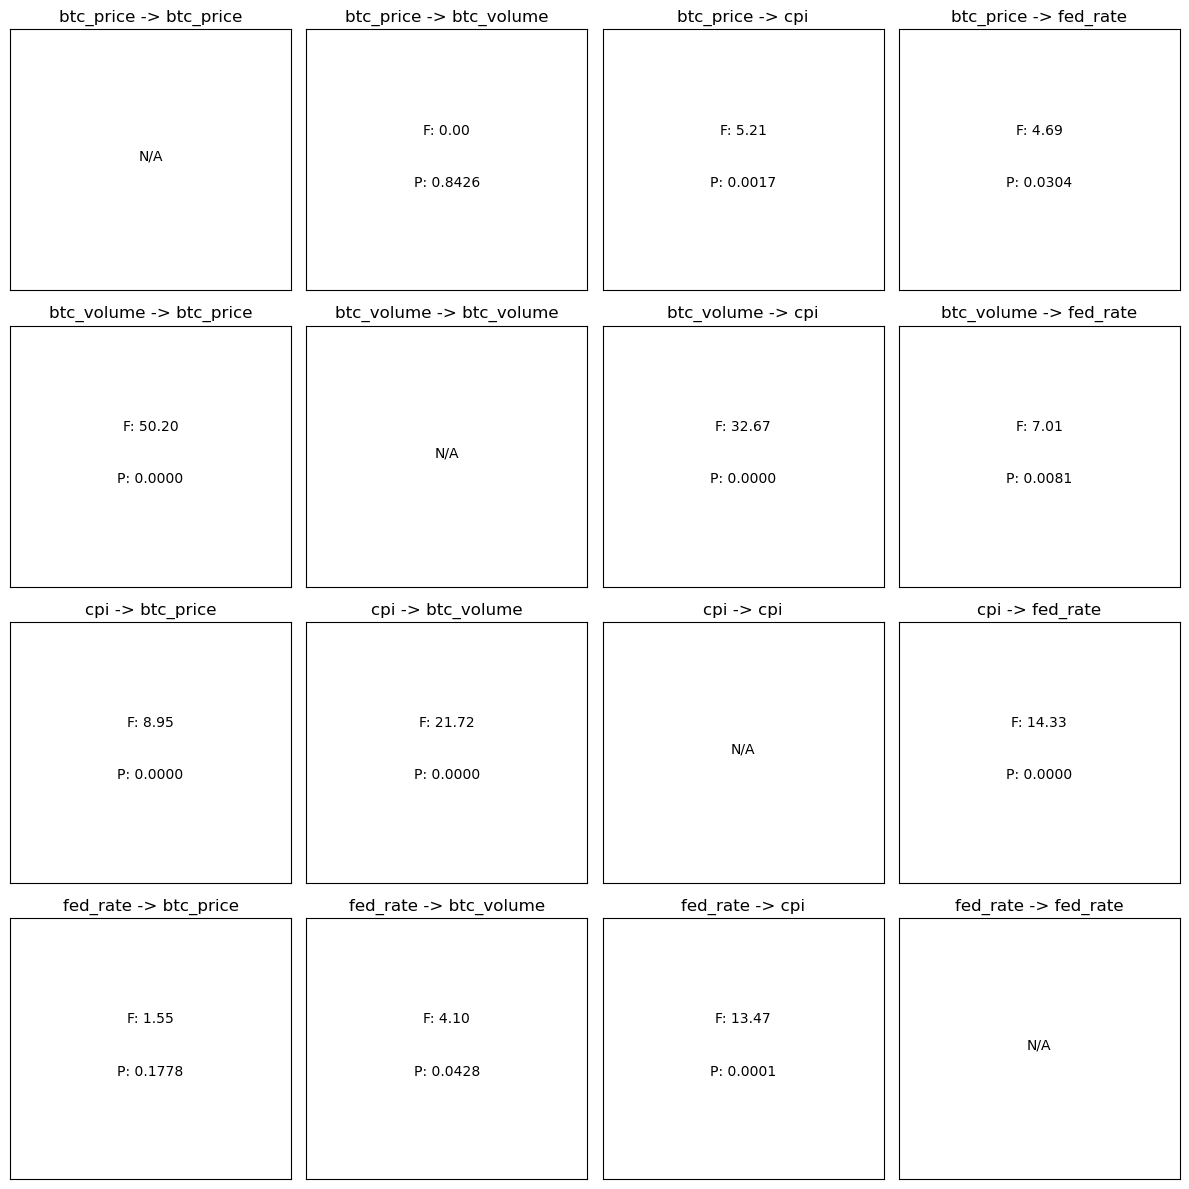

In [136]:
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

# 假设你的DataFrame df 已经定义并且清洗完成
# 确保'date'列是日期类型，如果你的DataFrame中包含这个列的话
# df['date'] = pd.to_datetime(df['date'])

# 定义变量列表
variables = ['btc_price', 'btc_volume', 'cpi', 'fed_rate']  # 根据你的数据调整这些变量名

# 执行格兰杰因果检验并收集结果
granger_test_results = {}
for var1 in variables:
    for var2 in variables:
        if var1 != var2:  # 避免自己对自己进行检验
            test_result = grangercausalitytests(df[[var1, var2]], maxlag=4, verbose=False)
            # 提取最小的p值和对应的F统计量
            min_p_value = min(test_result[lag][0]['ssr_chi2test'][1] for lag in test_result)
            f_statistic = test_result[1][0]['ssr_chi2test'][0]  # 以lag=1的F统计量为例
            granger_test_results[(var1, var2)] = (f_statistic, min_p_value)

# 绘制结果
plt.figure(figsize=(12, 12))
subplot_index = 1
for var1 in variables:
    for var2 in variables:
        ax = plt.subplot(4, 4, subplot_index)
        if var1 != var2 and (var1, var2) in granger_test_results:
            f_statistic, p_value = granger_test_results[(var1, var2)]
            ax.text(0.5, 0.6, f'F: {f_statistic:.2f}', ha='center')
            ax.text(0.5, 0.4, f'P: {p_value:.4f}', ha='center')
        else:
            ax.text(0.5, 0.5, 'N/A', ha='center')
        ax.set_title(f'{var1} -> {var2}')
        ax.set_xticks([])
        ax.set_yticks([])
        subplot_index += 1
plt.tight_layout()
plt.show()



## LSTM  对于比特币预测

In [137]:
import gc
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

# 数据归一化
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df[['btc_price', 'btc_volume', 'cpi']])

# 准备LSTM输入数据
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X, y = create_dataset(data_scaled, data_scaled[:, 0], time_steps)
X_train, X_test = X[:int(X.shape[0]*0.8)], X[int(X.shape[0]*0.8):]
y_train, y_test = y[:int(y.shape[0]*0.8)], y[int(y.shape[0]*0.8):]

In [138]:
## 超参数设置
neurons = 512
activation_function = 'tanh'
loss = 'mse'
optimizer="adam"
dropout = 0.25
batch_size = 12
epochs = 1      ###为了节约时间，循环仅1次
window_len = 7
training_size = 0.8


def build_model(inputs, output_size, neurons, activ_func=activation_function, dropout=dropout, loss=loss, optimizer=optimizer):
  """
  inputs: input data as numpy array
  output_size: number of predictions per input sample
  neurons: number of neurons/ units in the LSTM layer
  active_func: Activation function to be used in LSTM layers and Dense layer
  dropout: dropout ration, default is 0.25
  loss: loss function for calculating the gradient
  optimizer: type of optimizer to backpropagate the gradient
  This function will build 3 layered RNN model with LSTM cells with dripouts after each LSTM layer 
  and finally a dense layer to produce the output using keras' sequential model.
  Return: Keras sequential model and model summary
  """
  model = Sequential()
  model.add(LSTM(neurons, return_sequences=True, input_shape=(inputs.shape[1], inputs.shape[2]), activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, return_sequences=True, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(LSTM(neurons, activation=activ_func))
  model.add(Dropout(dropout))
  model.add(Dense(units=output_size))
  model.add(Activation(activ_func))
  model.compile(loss=loss, optimizer=optimizer, metrics=['mae'])
  model.summary()
  return model


In [139]:
# initialise model architecture
btc_model = build_model(X_train, output_size=1, neurons=neurons)
# train model on data
btc_history = btc_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(X_test, y_test), shuffle=False)

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_44 (LSTM)              (None, 10, 512)           1056768   
                                                                 
 dropout_36 (Dropout)        (None, 10, 512)           0         
                                                                 
 lstm_45 (LSTM)              (None, 10, 512)           2099200   
                                                                 
 dropout_37 (Dropout)        (None, 10, 512)           0         
                                                                 
 lstm_46 (LSTM)              (None, 512)               2099200   
                                                                 
 dropout_38 (Dropout)        (None, 512)               0         
                                                                 
 dense_21 (Dense)            (None, 1)               

30/30 [==============================] - 1s 38ms/step


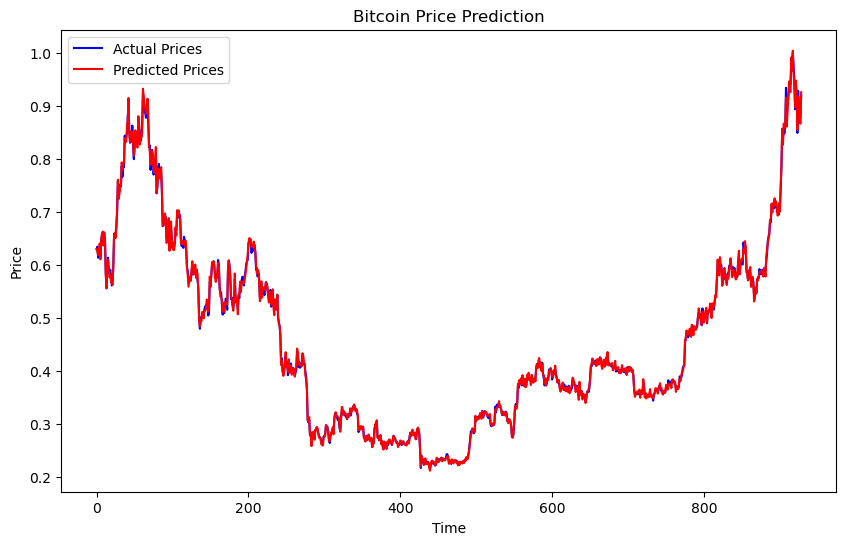

In [128]:
# 使用模型进行预测
predicted_prices = btc_model.predict(X_test)                                                                                                                                         


# 绘制预测结果和实际结果
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual Prices', color='blue')
plt.plot(Predicted_prices, label='Predicted Prices', color='red')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## 情感分析2.0

把数据库中新的情感数据条数据转变日数据，与下面类似

In [146]:
# 使用Pandas的read_sql_query函数查询btc_daily_info表的列信息
query = """
SELECT COLUMN_NAME 
FROM information_schema.COLUMNS 
WHERE 
    TABLE_SCHEMA = 'bitcoin_wxc' AND 
    TABLE_NAME = 'talk_subjects';
"""
df_columns = pd.read_sql_query(query, engine)

print(df_columns)

                 COLUMN_NAME
0                       date
1               talk_subject
2       talk_subject_emotion
3       talk_subject_replies
4  talk_subject_subjectivity
5         talk_subject_views


In [148]:
# 使用Pandas的read_sql_query函数加载数据
query = """
SELECT date,  talk_subject_emotion, talk_subject_replies, talk_subject_subjectivity, talk_subject_views
FROM talk_subjects 
WHERE date >= '2011-07-01'
"""

df = pd.read_sql_query(query, engine)

print(df.head(30))  # 打印前几行数据以验证

          date  talk_subject_emotion  talk_subject_replies  \
0   2020-06-23               -0.5000                    25   
1   2018-02-21                0.0000                     2   
2   2016-10-31                0.5000                    31   
3   2014-03-10                0.0000                    74   
4   2012-06-17                0.0000                     5   
5   2019-05-26                0.2000                    20   
6   2023-08-19                0.0000                    32   
7   2013-12-16                0.0000                     2   
8   2015-01-29                0.5000                    29   
9   2018-06-27                0.5000                   866   
10  2013-01-06                0.0000                    18   
11  2018-02-01                0.0000                     0   
12  2020-06-24                0.0000                    22   
13  2014-01-09                0.0000                     0   
14  2015-08-22                0.2500                     1   
15  2017

In [149]:
 # 确保date列是datetime类型
df['date'] = pd.to_datetime(df['date'])
    
# 对每个日期的情感分数进行加权平均
# 权重由views列给出
weighted_sentiment = df.groupby('date').apply(lambda x: (x['talk_subject_emotion'] * x['talk_subject_views']).sum() / x['talk_subject_views'].sum())
weighted_subjectivity = df.groupby('date').apply(lambda x: (x['talk_subject_subjectivity'] * x['talk_subject_views']).sum() / x['talk_subject_views'].sum())
    
# 将结果合并为一个新的DataFrame
result_df = pd.DataFrame({
    'weighted_sentiment': weighted_sentiment,
    'weighted_subjectivity': weighted_subjectivity
}).reset_index()

print(result_df) 

           date  weighted_sentiment  weighted_subjectivity
0    2011-07-01            0.071829               0.192810
1    2011-07-02            0.034799               0.207811
2    2011-07-03           -0.004825               0.156514
3    2011-07-04            0.188770               0.454356
4    2011-07-05            0.052814               0.221857
...         ...                 ...                    ...
4631 2024-03-28            0.035164               0.172590
4632 2024-03-29            0.000000               0.375421
4633 2024-03-30           -0.073151               0.260093
4634 2024-03-31            0.077544               0.186733
4635 2024-04-01            0.000000               0.000000

[4636 rows x 3 columns]


# 其他代码

## 比特币数据预处理

In [13]:
import csv
import pandas as pd
from datetime import datetime

def convert_k_to_thousand(value):
    """
    如果值以'K'结尾，则将其转换为相应的数值乘以1000。
    否则，返回原始值。
    """
    if isinstance(value, str) and value.upper().endswith('K'):
        return float(value[:-1]) * 1000
    return value

def convert_to_datetime(value, date_format):
    """
    将字符串转换为datetime对象。
    """
    try:
        return datetime.strptime(value, date_format)
    except ValueError:
        # 如果转换失败，返回原始值
        return value
    
    
def process_csv(input_file, output_file, columns_to_delete=None):
    """
    读取一个CSV文件，将所有以'K'结尾的数字转换成其对应的数值乘以1000，
    删除指定的多个列，然后将处理后的数据写入到另一个CSV文件。
    """
    with open(input_file, mode='r', newline='', encoding='utf-8') as infile, \
         open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        
        for row in reader:
            # 转换数字
            row[5] = convert_k_to_thousand(row[5])
            
            # 写入时将datetime对象格式化为字符串
            row = [value.strftime(date_format) if isinstance(value, datetime) else value for value in row]
            writer.writerow(row)


# 使用示例
input_csv = 'input.csv'  # 输入文件的路径
output_csv = 'output.csv'  # 输出文件的路径

atetime_column = 0
process_csv(input_csv, output_csv)


In [14]:
import csv

def process_csv_simple(input_file, output_file, columns_to_delete):
    """
    读取一个CSV文件，删除指定的多个列，然后将处理后的数据写入到另一个CSV文件。
    - input_file: 输入文件路径
    - output_file: 输出文件路径
    - columns_to_delete: 要删除的列索引列表
    """
    with open(input_file, mode='r', newline='', encoding='utf-8') as infile, \
         open(output_file, mode='w', newline='', encoding='utf-8') as outfile:
        reader = csv.reader(infile)
        writer = csv.writer(outfile)
        
        for row in reader:
            # 删除指定列：通过列表推导式保留未指定删除的列
            row = [item for index, item in enumerate(row) if index not in columns_to_delete]
            writer.writerow(row)

# 使用示例
input_csv = 'output.csv'  # 输入文件的路径
output_csv = 'output2.csv'  # 输出文件的路径
columns_to_delete = [2, 3, 4, 6] 

process_csv_simple(input_csv, output_csv, columns_to_delete)


## 情感分析

In [15]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 指定你的Excel文件路径
file_path = 'output.xlsx'

# 读取Excel文件
df = pd.read_excel(file_path)

# 确保"subject"列存在
if 'title' in df.columns:
    # 初始化VADER情感分析器
    analyzer = SentimentIntensityAnalyzer()
    
    # 对每个标题进行情感和主观性分析
    df['vader_sentiment'] = df['title'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    df['textblob_subjectivity'] = df['title'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # 查看结果
    print(df[['title', 'vader_sentiment', 'textblob_subjectivity']])
else:
    print("The 'subject' column does not exist in the Excel file.")

# 指定输出CSV文件的路径
output_csv_path = '按条的情感分析_新闻.csv'

# 导出DataFrame到CSV，不包含行索引
df[['seendate', 'title', 'vader_sentiment', 'textblob_subjectivity']].to_csv(output_csv_path, index=False)

print(f"Data exported successfully to {output_csv_path}")
    

                                                  title  vader_sentiment  \
0     The Crypto Daily – Movers and Shakers – 01 / 0...           0.0772   
1     Bitcoin : 4 Big Competitive Advantages Over Al...           0.4939   
2                      2010s In Bitcoin : The Year 2019           0.0000   
3     McAfee Prediction : Only 365 Days Left , Bitco...           0.0000   
4     Bitcoin Closed Q4 in Losses ; Two Major Cataly...          -0.4019   
...                                                 ...              ...   
1447  Fugitive Ghosn brings global attention to Japa...           0.5267   
1448  Fugitive Ghosn brings global attention to Japa...           0.5267   
1449  Fugitive Ghosn brings global attention to Japa...           0.5267   
1450  dartwatch . com Website Analysis and Social Me...           0.0000   
1451        Meet The 2020 Sales & Marketers of The Year           0.0000   

      textblob_subjectivity  
0                  0.000000  
1                  0.100000

In [13]:
import pandas as pd
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 指定你的Excel文件路径
file_path = 'bitcointalkforum.xlsx'

# 读取Excel文件
df = pd.read_excel(file_path)

# 确保"subject"列存在
if 'subject' in df.columns:
    # 初始化VADER情感分析器
    analyzer = SentimentIntensityAnalyzer()
    
    # 对每个标题进行情感和主观性分析
    df['vader_sentiment'] = df['subject'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
    df['textblob_subjectivity'] = df['subject'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

    # 查看结果
    print(df[['subject', 'vader_sentiment', 'textblob_subjectivity']])
else:
    print("The 'subject' column does not exist in the Excel file.")

# 指定输出CSV文件的路径
output_csv_path = '按条的情感分析.csv'

# 导出DataFrame到CSV，不包含行索引
df[['date', 'subject', 'vader_sentiment', 'textblob_subjectivity']].to_csv(output_csv_path, index=False)

print(f"Data exported successfully to {output_csv_path}")
    

                                                 subject  vader_sentiment  \
0         We should be looking only at the brighter side           0.3818   
1      When will Michael Saylor and MicroStrategy sel...           0.0000   
2                  DCA vs Smart DCA, what do you choose?           0.4019   
3      El Salvador has become the first country to ma...           0.2003   
4                            Is It Time to Buy More BTC?           0.0000   
...                                                  ...              ...   
61120                                Dynamic DNS Support           0.6486   
61121                          Questions about Addresses           0.0000   
61122                                      64bit support           0.4019   
61123                              Bitcoin 0.2 released!           0.0000   
61124  Is my second Transaction working correctly? +T...           0.0000   

       textblob_subjectivity  
0                   1.000000  
1            

In [11]:
 # 确保date列是datetime类型
df['date'] = pd.to_datetime(df['date'])
    
# 对每个日期的情感分数进行加权平均
# 权重由views列给出
weighted_sentiment = df.groupby('date').apply(lambda x: (x['vader_sentiment'] * x['views']).sum() / x['views'].sum())
weighted_subjectivity = df.groupby('date').apply(lambda x: (x['textblob_subjectivity'] * x['views']).sum() / x['views'].sum())
    
# 将结果合并为一个新的DataFrame
result_df = pd.DataFrame({
    'weighted_sentiment': weighted_sentiment,
    'weighted_subjectivity': weighted_subjectivity
}).reset_index()

print(result_df) 

In [14]:
# 指定输出CSV文件的路径
output_csv_path = '以views为权重生成的按日的情感分析.csv'

# 导出DataFrame到CSV，不包含行索引
result_df.to_csv(output_csv_path, index=False)

print(f"Data exported successfully to {output_csv_path}")


Data exported successfully to 以views为权重生成的按日的情感分析.csv
